In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.ticker as ticker
import seaborn as sns
%cd '/jetfs/home/a12233665/pai-munich-vienna/'

from scipy.interpolate import LinearNDInterpolator
from datetime import datetime
from joblib import Parallel, delayed
from joblib.externals.loky import set_loky_pickler
set_loky_pickler('pickle')
from numba import njit
from pathlib import Path
import gc

from kendapy.ekf import Ekf
from enstools.io import read, write

import pai.observation as oi
from pai.localization import get_dist_from_obs, find_analysis_in_area
import pai.pai_utils as paiut
import pai.partial_analysis_increment_np as PAI
import pai.plot_oi_utils as utils

import cartopy.crs as ccrs

import cProfile, pstats, io
from pstats import SortKey
import time

from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units

/jetfs/home/a12233665/.local/lib/python3.8/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


/jetfs/home/a12233665/pai-munich-vienna


In [6]:
Benefit_ds6 = xr.open_dataset('/jetfs/shared-data/ICON-LAM-DWD/exp_2/Results/Table_Computations_VIS6_1_30.nc')
Benefit_ds9 = xr.open_dataset('/jetfs/shared-data/ICON-LAM-DWD/exp_2/Results/Table_Computations_VIS9_1_30.nc')
Benefit_ds12 = xr.open_dataset('/jetfs/shared-data/ICON-LAM-DWD/exp_2/Results/Table_Computations_VIS12_1_30.nc')
Benefit_ds15 = xr.open_dataset('/jetfs/shared-data/ICON-LAM-DWD/exp_2/Results/Table_Computations_VIS15_1_30.nc')
Benefit_ds_VIS = xr.concat([Benefit_ds6, Benefit_ds9, Benefit_ds12, Benefit_ds15], dim='Observation')

In [7]:
Benefit_ds6 = xr.open_dataset('/jetfs/shared-data/ICON-LAM-DWD/exp_2/Results/Table_Computations_IR0_1_30.nc')
Benefit_ds12 = xr.open_dataset('/jetfs/shared-data/ICON-LAM-DWD/exp_2/Results/Table_Computations_IR0_12_1_30.nc')
Benefit_ds0 = xr.open_dataset('/jetfs/shared-data/ICON-LAM-DWD/exp_2/Results/Table_Computations_IR0_0_1_30.nc')
Benefit_ds_IR0 = xr.concat([Benefit_ds0, Benefit_ds6, Benefit_ds12], dim='Observation')

In [8]:
Benefit_ds6 = xr.open_dataset('/jetfs/shared-data/ICON-LAM-DWD/exp_2/Results/Table_Computations_IR1_1_30.nc')
Benefit_ds12 = xr.open_dataset('/jetfs/shared-data/ICON-LAM-DWD/exp_2/Results/Table_Computations_IR1_12_1_30.nc')
Benefit_ds0 = xr.open_dataset('/jetfs/shared-data/ICON-LAM-DWD/exp_2/Results/Table_Computations_IR1_0_1_30.nc')
Benefit_ds_IR1 = xr.concat([Benefit_ds0, Benefit_ds6, Benefit_ds12], dim='Observation')

In [9]:
def Compare_Loc_Functions(Benefit_DS):
    Days = Benefit_DS.day.values
    Times = Benefit_DS.Time.values
    Rep_indices = Benefit_DS.rep_num.values
    Veri_types = Benefit_DS.veri_obs_type.values

    # Create a multi-index with year, month, day, and hour
    multi_index = pd.MultiIndex.from_arrays(
        [Days, Times, Rep_indices, Veri_types],
        names=['day', 'time', 'rep_num', 'veri_obs_type']
        )
    # Convert the multi-index to a DataArray
    multi_index_da = xr.DataArray(multi_index, dims=['Observation'], coords={'veri_obs_type': Benefit_DS.veri_obs_type})

    # Group by the multi-index DataArray and sum the values
    DS = Benefit_DS.groupby(multi_index_da).mean()
    for loc_function in DS.localisation.values:
        #print(type(str(DS.where((DS.veri_obs_type=='T')*(DS.localisation==loc_function), drop = True).err_new_loc.sum().values)))#.astype(str)))
        #print(type(loc_function))
        print(loc_function + ', T: ' + str(DS.where((DS.group_level_3=='T')*(DS.localisation==loc_function), drop = True).err_new_loc.sum().values))
        print(loc_function + ', RH:' + str(DS.where((DS.group_level_3=='RH')*(DS.localisation==loc_function), drop = True).err_new_loc.sum().values))
        print(loc_function + ', global:' + str(DS.where(DS.localisation==loc_function).err_new_loc.sum().values))

In [10]:
def Loc_Function_Results(Benefit_DS):
    Days = Benefit_DS.day.values
    Times = Benefit_DS.Time.values
    Rep_indices = Benefit_DS.rep_num.values
    Veri_types = Benefit_DS.veri_obs_type.values

    # Create a multi-index with year, month, day, and hour
    multi_index = pd.MultiIndex.from_arrays(
        [Days, Times, Rep_indices, Veri_types],
        names=['day', 'time', 'rep_num', 'veri_obs_type']
        )
    # Convert the multi-index to a DataArray
    multi_index_da = xr.DataArray(multi_index, dims=['Observation'], coords={'veri_obs_type': Benefit_DS.veri_obs_type})

    # Group by the multi-index DataArray and sum the values
    DS = Benefit_DS.groupby(multi_index_da).mean()
    T_errors = []
    RH_errors = []
    global_errors = []
    for loc_function in DS.localisation.values:
        #print(type(str(DS.where((DS.veri_obs_type=='T')*(DS.localisation==loc_function), drop = True).err_new_loc.sum().values)))#.astype(str)))
        #print(type(loc_function))
        #print(loc_function + ', T: ' + str(DS.where((DS.group_level_3=='T')*(DS.localisation==loc_function), drop = True).err_new_loc.sum().values))
        #print(loc_function + ', RH:' + str(DS.where((DS.group_level_3=='RH')*(DS.localisation==loc_function), drop = True).err_new_loc.sum().values))
        #print(loc_function + ', global:' + str(DS.where(DS.localisation==loc_function).err_new_loc.sum().values))
        T_errors.append((DS.where((DS.group_level_3=='T')*(DS.localisation==loc_function), drop = True).err_new_loc.sum().values) /
                        (DS.where((DS.group_level_3=='T')*(DS.localisation=='GC_no_obs'), drop = True).err_new_loc.sum().values))
        RH_errors.append((DS.where((DS.group_level_3=='RH')*(DS.localisation==loc_function), drop = True).err_new_loc.sum().values) /
                         (DS.where((DS.group_level_3=='RH')*(DS.localisation=='GC_no_obs'), drop = True).err_new_loc.sum().values))
        global_errors.append((DS.where(DS.localisation==loc_function).err_new_loc.sum().values) /
                             (DS.where(DS.localisation=='GC_no_obs').err_new_loc.sum().values))
    return [DS.localisation.values, T_errors, RH_errors, global_errors]

In [11]:
Results_VIS = Loc_Function_Results(Benefit_ds_VIS)
Results_IR0 = Loc_Function_Results(Benefit_ds_IR0)
Results_IR1 = Loc_Function_Results(Benefit_ds_IR1)

In [12]:
## Get DWD settings, these are experiments at different indices for each.
print(Results_VIS[0])
Results_VIS[0] = np.append(Results_VIS[0], 'DWD Settings')
Results_VIS[1].append(Results_VIS[1][3])
Results_VIS[2].append(Results_VIS[2][3])
Results_VIS[3].append(Results_VIS[3][3])

Results_IR0[0] = np.append(Results_IR0[0], 'DWD Settings')
Results_IR0[1].append(Results_IR0[1][0])
Results_IR0[2].append(Results_IR0[2][0])
Results_IR0[3].append(Results_IR0[3][0])

Results_IR1[0] = np.append(Results_IR1[0], 'DWD Settings')
Results_IR1[1].append(Results_IR1[1][0])
Results_IR1[2].append(Results_IR1[2][0])
Results_IR1[3].append(Results_IR1[3][0])

## Make optimal VIS value 'no loc'
Results_VIS[1][3] = Results_VIS[1][1]
Results_VIS[2][3] = Results_VIS[2][1]
Results_VIS[3][3] = Results_VIS[3][1]

['Ana_error' 'GC_no_loc' 'GC_no_obs' 'GC_1' 'GC_2' 'GC_3' 'GC_4'
 'GC_two_peak_1' 'GC_two_peak_2' 'GC_two_peak_3' 'GC_two_peak_4'
 'ELF_full' 'ELF_above' 'ELF_below']


In [ ]:
#print(Results_VIS[0])
full_sample_columns = np.array([0, 1, 2, 3, 7, 11, 14])
#print(full_sample_columns)
Results_concat = np.concatenate([np.array(Results_VIS[1:])[:,full_sample_columns], 
                                 np.array(Results_IR0[1:])[:,full_sample_columns],#.reshape(15, 3),
                                 np.array(Results_IR1[1:])[:,full_sample_columns]], axis=0)
print(Results_concat)
Results_Frame_Full_Sample = pd.DataFrame(Results_concat - 1, columns=np.array(Results_VIS[0])[full_sample_columns], 
                             index=["T_error_VIS", "RH_error_VIS", "global_error_VIS",
                                    "T_error_IR0", "RH_error_IR0", "global_error_IR0",
                                    "T_error_IR1", "RH_error_IR1", "global_error_IR1"])

In [15]:
def cloud_on_off_loc_score(Benefit_DS, cloud_variable, cloud_threshold, cloud_above = True, loc_function_cloud ='GC_2', loc_function_no_cloud = 'GC_3'):
    Days = Benefit_DS.day.values
    Times = Benefit_DS.Time.values
    Rep_indices = Benefit_DS.rep_num.values
    Veri_types = Benefit_DS.veri_obs_type.values

    # Create a multi-index with year, month, day, and hour
    multi_index = pd.MultiIndex.from_arrays(
        [Days, Times, Rep_indices, Veri_types],
        names=['day', 'time', 'rep_num', 'veri_obs_type']
        )
    # Convert the multi-index to a DataArray
    multi_index_da = xr.DataArray(multi_index, dims=['Observation'], coords={'veri_obs_type': Benefit_DS.veri_obs_type})

    # Group by the multi-index DataArray and sum the values
    DS = Benefit_DS.groupby(multi_index_da).mean()
    
    if cloud_above:
        cloud_on_mask = DS[cloud_variable] > cloud_threshold
    else:
        cloud_on_mask = DS[cloud_variable] < cloud_threshold

    cloud_on = DS.where(cloud_on_mask, drop = True)
    cloud_off = DS.where(~cloud_on_mask, drop = True)
    err_cloud_onT = cloud_on.where((cloud_on.group_level_3=='T')*(cloud_on.localisation==loc_function_cloud), drop = True).err_new_loc.sum().values
    err_cloud_offT = cloud_off.where((cloud_off.group_level_3=='T')*(cloud_off.localisation==loc_function_no_cloud), drop = True).err_new_loc.sum().values
    print('Cloud on T error: ' + str(err_cloud_onT))
    print('Cloud off T error: ' + str(err_cloud_offT))
    print('T error:' + str(err_cloud_onT + err_cloud_offT))

    err_cloud_onRH = cloud_on.where((cloud_on.group_level_3=='RH')*(cloud_on.localisation==loc_function_cloud), drop = True).err_new_loc.sum().values
    err_cloud_offRH = cloud_off.where((cloud_off.group_level_3=='RH')*(cloud_off.localisation==loc_function_no_cloud), drop = True).err_new_loc.sum().values
    print('Cloud on RH error: ' + str(err_cloud_onRH))
    print('Cloud off RH error: ' + str(err_cloud_offRH))
    print('RH error:' + str(err_cloud_onRH + err_cloud_offRH))

    print('Cloud on full error: ' + str(err_cloud_onT + err_cloud_onRH))
    print('Cloud off full error: ' + str(err_cloud_offT + err_cloud_offRH))
    print('Full error: ' + str(err_cloud_onT + err_cloud_onRH + err_cloud_offT + err_cloud_offRH))

    print(f'& {err_cloud_onT + err_cloud_offT} & {err_cloud_onRH + err_cloud_offRH} & {err_cloud_onT + err_cloud_onRH + err_cloud_offT + err_cloud_offRH}')
    

In [16]:
def cloud_on_off_loc_result(Benefit_DS, cloud_variable, cloud_threshold, cloud_above = True, loc_functions_cloud = ['GC_2', 'GC_two_peak_2', 'ELF_above'], loc_functions_no_cloud = ['GC_3', 'GC_two_peak_3', 'ELF_below']):
    Days = Benefit_DS.day.values
    Times = Benefit_DS.Time.values
    Rep_indices = Benefit_DS.rep_num.values
    Veri_types = Benefit_DS.veri_obs_type.values

    # Create a multi-index with year, month, day, and hour
    multi_index = pd.MultiIndex.from_arrays(
        [Days, Times, Rep_indices, Veri_types],
        names=['day', 'time', 'rep_num', 'veri_obs_type']
        )
    # Convert the multi-index to a DataArray
    multi_index_da = xr.DataArray(multi_index, dims=['Observation'], coords={'veri_obs_type': Benefit_DS.veri_obs_type})

    # Group by the multi-index DataArray and sum the values
    DS = Benefit_DS.groupby(multi_index_da).mean()
    
    if cloud_above:
        cloud_on_mask = DS[cloud_variable] > cloud_threshold
    else:
        cloud_on_mask = DS[cloud_variable] < cloud_threshold

    cloud_on = DS.where(cloud_on_mask, drop = True)
    cloud_off = DS.where(~cloud_on_mask, drop = True)
    T_errors = []
    RH_errors = []
    global_errors = []
    for ind, loc_function_cloud in enumerate(loc_functions_cloud):
        loc_function_no_cloud = loc_functions_no_cloud[ind]
        err_cloud_onT = cloud_on.where((cloud_on.group_level_3=='T')*(cloud_on.localisation==loc_function_cloud), drop = True).err_new_loc.sum().values
        err_cloud_offT = cloud_off.where((cloud_off.group_level_3=='T')*(cloud_off.localisation==loc_function_no_cloud), drop = True).err_new_loc.sum().values
        T_errors.append((err_cloud_onT + err_cloud_offT) / 
                        DS.where((DS.group_level_3=='T')*(DS.localisation=='GC_no_obs'), drop = True).err_new_loc.sum().values)
        #print('Cloud on T error: ' + str(err_cloud_onT))
        #print('Cloud off T error: ' + str(err_cloud_offT))
        #print('T error:' + str(err_cloud_onT + err_cloud_offT))

        err_cloud_onRH = cloud_on.where((cloud_on.group_level_3=='RH')*(cloud_on.localisation==loc_function_cloud), drop = True).err_new_loc.sum().values
        err_cloud_offRH = cloud_off.where((cloud_off.group_level_3=='RH')*(cloud_off.localisation==loc_function_no_cloud), drop = True).err_new_loc.sum().values
        RH_errors.append((err_cloud_onRH + err_cloud_offRH) /
                         DS.where((DS.group_level_3=='RH')*(DS.localisation=='GC_no_obs'), drop = True).err_new_loc.sum().values)
        #print('Cloud on RH error: ' + str(err_cloud_onRH))
        #print('Cloud off RH error: ' + str(err_cloud_offRH))
        #print('RH error:' + str(err_cloud_onRH + err_cloud_offRH))

        #print('Cloud on full error: ' + str(err_cloud_onT + err_cloud_onRH))
        #print('Cloud off full error: ' + str(err_cloud_offT + err_cloud_offRH))
        #print('Full error: ' + str(err_cloud_onT + err_cloud_onRH + err_cloud_offT + err_cloud_offRH))
        global_errors.append((err_cloud_onT + err_cloud_onRH + err_cloud_offT + err_cloud_offRH) /
                             DS.where(DS.localisation=='GC_no_obs', drop = True).err_new_loc.sum().values)

        #print(f'& {err_cloud_onT + err_cloud_offT} & {err_cloud_onRH + err_cloud_offRH} & {err_cloud_onT + err_cloud_onRH + err_cloud_offT + err_cloud_offRH}')
    return [['GC_onoff', 'GC_onoff_multipeak', 'ELF_onoff'], T_errors, RH_errors, global_errors]

In [17]:
COOKIE_VIS = cloud_on_off_loc_result(Benefit_ds_VIS, 'VIS_value', 0.4, cloud_above = True, 
                                     loc_functions_cloud = ['GC_3', 'GC_two_peak_2', 'ELF_above'], 
                                     loc_functions_no_cloud = ['GC_4', 'GC_4', 'ELF_below'])
COOKIE_IR0 = cloud_on_off_loc_result(Benefit_ds_IR0, 'IR0_value', 233, cloud_above = False,
                                     loc_functions_cloud=['GC_3', 'GC_two_peak_3', 'ELF_below'],
                                     loc_functions_no_cloud=['GC_1', 'GC_two_peak_2', 'ELF_above'])
COOKIE_IR1 = cloud_on_off_loc_result(Benefit_ds_IR1, 'IR1_value', 252, cloud_above = False,
                                     loc_functions_cloud=['GC_1', 'GC_1', 'ELF_below'],
                                     loc_functions_no_cloud=['GC_2', 'GC_1', 'ELF_above'])

In [20]:
COOKIE_VIS

[['GC_onoff', 'GC_onoff_multipeak', 'ELF_onoff'],
 [0.9949046376056547, 0.9935211804297104, 0.9931208348774333],
 [0.9970166930177833, 0.9962998334132077, 0.9963425757768138],
 [0.9961540321708381, 0.9951649033719099, 0.9950266681936427]]

In [18]:
Results_concat_COOKIE = np.concatenate([np.array(COOKIE_VIS[1:]), 
                                 np.array(COOKIE_IR0[1:]),
                                 np.array(COOKIE_IR1[1:])], axis=0)
#print(Results_concat)
Results_Frame_COOKIE = pd.DataFrame(Results_concat_COOKIE - 1, columns=np.array(COOKIE_VIS[0]), 
                             index=["T_error_VIS", "RH_error_VIS", "global_error_VIS",
                                    "T_error_IR0", "RH_error_IR0", "global_error_IR0",
                                    "T_error_IR1", "RH_error_IR1", "global_error_IR1"])

In [19]:
Results_Frame = pd.concat([Results_Frame_Full_Sample, Results_Frame_COOKIE])


In [20]:
Results_Frame.columns.values

array(['Ana_error', 'GC_no_loc', 'GC_no_obs', 'GC_1', 'GC_two_peak_1',
       'ELF_full', 'DWD Settings', 'GC_onoff', 'GC_onoff_multipeak',
       'ELF_onoff'], dtype=object)

In [21]:
Results_Frame = Results_Frame_Full_Sample.join(Results_Frame_COOKIE)
Results_Frame = Results_Frame[['Ana_error', 'DWD Settings',
                               'GC_no_loc', 'GC_no_obs', 
                               'GC_1', 
                               'ELF_full', 'GC_two_peak_1']]
Results_Frame = Results_Frame.rename(columns={'Ana_error':'Error for experiment\nsettings', 
                                              'GC_no_loc':'No localisation', 
                                              'GC_no_obs':'Observation removed', 
                                              'GC_1':'Global optimal\nGaspari-Cohn', 
                                              'GC_two_peak_1':'Multi-peak GC fitted\nto global ELF',
                                              'ELF_full':'Global ELF'})
Results_Frame = Results_Frame.drop('Observation removed', axis = 'columns')
Results_Frame = Results_Frame.rename(index={'T_error_VIS':'Temperature\nerror VIS 0.6', 'RH_error_VIS':'RH error\nVIS 0.6', 'global_error_VIS':'Global error\nVIS 0.6',
                                            'T_error_IR0':'Temperature\nerror IR 6.2', 'RH_error_IR0':'RH error\nIR 6.2', 'global_error_IR0':'Global error\nIR 6.2',
                                            'T_error_IR1':'Temperature\nerror IR 7.3', 'RH_error_IR1':'RH error\nIR 7.3', 'global_error_IR1':'Global error\nIR 7.3'})

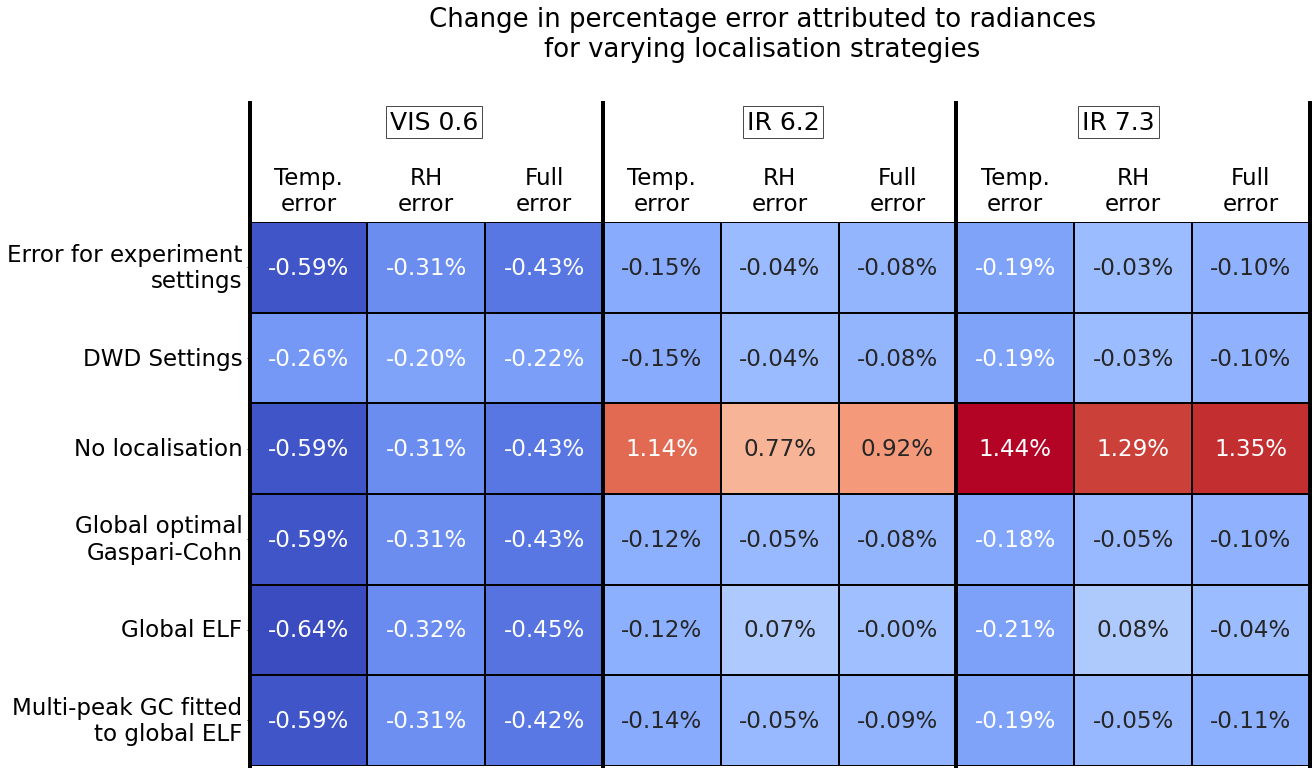

In [22]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(19, 10))
text_size = 23
g = sns.heatmap(Results_Frame.T, annot=True, fmt=".2%", cmap='coolwarm', cbar = False, annot_kws={'size': text_size},
            linewidths = 2, linecolor='black',
            xticklabels=['Temp.\nerror', 'RH\nerror', 'Full\nerror',
                         'Temp.\nerror', 'RH\nerror', 'Full\nerror',
                         'Temp.\nerror', 'RH\nerror', 'Full\nerror'])#, cbar_kws={'label': 'Relative error'})
ax.tick_params(axis='both', which='major', labelsize=text_size, labelbottom = False, bottom=False, top = False, labeltop=True)
g.set_yticklabels(g.get_yticklabels(), rotation=0)
#ax.axvline(x = 0, ymax = 1.3, color='black', linewidth=8)
#ax.axvline(x = 3, ymax = 1.3, color='black', linewidth=4)
#ax.axvline(x = 6, color='black', linewidth=4)
#ax.axvline(x = 9, color='black', linewidth=4)
#ax.axvline(x = 12, color='black', linewidth=8)
x0 = ax.get_position().x0
x1 = ax.get_position().x1
y0 = ax.get_position().y0
y1 = ax.get_position().y1
fig.add_artist(lines.Line2D([x0, x0], [y0, y0 + 1.22*(y1 - y0)], 
                            color = 'black', linewidth = 4))
fig.add_artist(lines.Line2D([x0 + (1/3)*(x1 - x0), x0 + (1/3)*(x1 - x0)], [y0, y0 + 1.22*(y1 - y0)],
                            color = 'black', linewidth = 4))
fig.add_artist(lines.Line2D([x0 + (2/3)*(x1 - x0), x0 + (2/3)*(x1 - x0)], [y0, y0 + 1.22*(y1 - y0)],
                            color = 'black', linewidth = 4))
fig.add_artist(lines.Line2D([x1, x1], [y0, y0 + 1.22*(y1 - y0)],
                            color = 'black', linewidth = 4))
#fig.add_artist(lines.Line2D([0, 1], [1, 0]))

fig.suptitle('Change in percentage error attributed to radiances\nfor varying localisation strategies', fontsize = text_size + 3, y = 1.18)
t1 = fig.text(0.26, 1.01, 'VIS 0.6', ha='center', fontsize = text_size + 2)
t1.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='black'))
t2 = fig.text(0.515, 1.01, 'IR 6.2', ha='center', fontsize = text_size + 2)
t2.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='black'))
t3 = fig.text(0.76, 1.01, 'IR 7.3', ha='center', fontsize = text_size + 2)
t3.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='black'))
fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/Error_reduction_for_paper.pdf', bbox_inches='tight')

In [ ]:
VIS_coeffs_04VIScloud_bounds_full = [0,  1, 0.83275683, 1, 0.7796353, 0.68094375, 0.43331787, 1, 1, 0.04846825, 1]
VIS_coeffs_04VIScloud_bounds_above = [0, 1, 0.78204852, 1, 0.6450851,  0, 0, 1, 1, 0, 1]
VIS_coeffs_04VIScloud_bounds_below = [0.65895695, 1, 0.87536263, 1, 0.8781595, 1, 0.65058917, 1, 0.3653289, 0.30794885, 0.5730768 ]

IR0_coeffs_233cloud_bounds_full = [0.0, 1.0, 0.4885386865028979, 0.23112258377954886, 0.0, 0.6438577601088938, 0.01663965031534579, 0.06922958558123664, 1.0, 0.0, 0.48505394981532035]
IR0_coeffs_233cloud_bounds_above = [0.0, 0.8590873579025468, 0.3881013003077521, 0.0, 0.0763737926860092, 0.92849341619604, 0.7197598365656169, 0.0, 1.0, 0.0, 0.008589622744443257]
IR0_coeffs_233cloud_bounds_below = [0.0, 1.0, 0.5306636828088477, 0.39814287684194244, 0.0, 0.49210662882405387, 0.0, 0.6276951490768374, 1.0, 0.191931378356844, 0.652267290531055]

IR1_coeffs_252cloud_bounds_full = [0.0, 0.6359517621168526, 0.7332342669784513, 0.10746331461598115, 0.07045728242739405, 0.0, 0.3531118523088319, 0.4236491682812797, 1.0, 0.0, 0.0]
IR1_coeffs_252cloud_bounds_above = [0.0, 0.0, 0.9182479139244245, 0.0, 1.0, 0.0, 0.0, 0.5206910989605144, 1.0, 0.0, 0.0]
IR1_coeffs_252cloud_bounds_below = [0.0, 0.8791418418599205, 0.6704410550122154, 0.19502954794216865, 0.0, 0.06108146041384197, 0.5045073192401709, 0.3869692068211075, 1.0, 0.0, 0.0]

Plot_GC_with_ELF(VIS_coeffs_04VIScloud_bounds_full, range(4, 65, 6), 35000, 0.5, Multi_Peak=True, GC_plev2=87000, GC_width2=0.1)
Plot_GC_with_ELF(VIS_coeffs_04VIScloud_bounds_above, range(4, 65, 6), 33000, 0.3, Multi_Peak=True, GC_plev2=90000, GC_width2=0.07)
Plot_GC_with_ELF(VIS_coeffs_04VIScloud_bounds_above, range(4, 65, 6), 33000, 0.4, Multi_Peak=True, GC_plev2=90000, GC_width2=0.1)
Plot_GC_with_ELF(VIS_coeffs_04VIScloud_bounds_below, range(4, 65, 6), 35000, 1, Multi_Peak=False)#, GC_plev2=90000, GC_width2=0.2)

